In [3]:
from evals_header import *
pd.set_option('display.max_rows', 200)
T = 0.9

def read_sweep(sweep_fn):
    sweep_df = pd.read_csv(sweep_fn, sep='\t', header=None)
    sweep_df.columns = ['query_name', 'k', 'P_sz','p_sz', 'matches', 'ref_start', 'ref_end', 'minx', 'J', 'runtime']
    sweep_df['J'] = sweep_df['J'].round(3)
    sweep_df['alignment_bps'] = sweep_df['ref_end'] - sweep_df['ref_start']
    return sweep_df

def add_TP_column(tested_df, groundtruth_df, TP_column_name):
    tested_df[TP_column_name] = tested_df.apply(lambda row: get_max_jaccard(row, groundtruth_df) >= T, axis=1)

def get_sensitivity(tested_df, truth_df):
    add_overlap_column(tested_df, truth_df, 'TP')
    add_overlap_column(truth_df, tested_df, 'TP')

    sensitivity = tested_df['TP'].sum() / tested_df.shape[0]  # TP / P
    specificity = truth_df['TP'].sum() / truth_df.shape[0]  # 1 - FP / N 

    display(tested_df.head())
    display(truth_df.head())

    #correct = df[df['overlap'] > 0.1].shape[0]
    #all = df.shape[0]
    #accuracy = correct / all
    #return correct, all, accuracy


In [6]:
# Input
reads_fn = 'simulations/reads/t2thumanChrY_sr0.0001090909090909091_dr0.0009818181818181818_i0.0009090909090909091_sd7361077429744071834_lmn100_lmx1000000_lavg9000_ls7000_dp10_rm20.fasta'
#eskemap_fn = 'out/eske100.out'
minimap_fn = 'out/minimap.out'
#sweep_fn = 'sweep-pairs-noblacklist.out'
#sweep_fn = 'out/sweep-b-a-fine.out'
#sweep_fn = 'sweep-normalized-intervals.out'

# Minimap
minimap_df = pd.read_csv(minimap_fn, sep='\t', header=None)
minimap_df.columns = ['query_name', 'query_len', 'query_start', 'query_end', 'strand', 'ref_name', 'ref_len', 'ref_start', 'ref_end', 'match_bases', 'total_bases', 'map_quality', 'cigar']

# Simulated reads
simulated_df = parse_fasta_metadata(reads_fn)

sweep_dfs = {}
params_dfs = pd.DataFrame()
# all files in which start with "sweep_"
for sweep_fn in glob.glob('out/sweep-b-a*.out'):
    print(sweep_fn)
    sweep_dfs[sweep_fn] = read_sweep(sweep_fn)
    sweep_dfs[sweep_fn] = pd.merge(simulated_df, sweep_dfs[sweep_fn], on='query_name', how='left')
    add_overlap_column(sweep_dfs[sweep_fn], minimap_df, 'overlap')
    correct, all, accuracy = get_accuracy(sweep_dfs[sweep_fn])
    # sensitivity = get_sensitivity(sweep_dfs[sweep_fn], minimap_df)
    # change the extension to '.params'
    continue
    params_fn = sweep_fn.replace('.out', '.params')
    params_df = pd.read_csv(params_fn, sep='\t')
    params_df['correct'], params_df['all'],params_df['accuracy'] = correct, all, accuracy
    #print('{} {:.2%} ({} / {})'.format(sweep_fn, accuracy, correct, all))
    params_dfs = pd.concat([params_dfs, params_df], axis=0)
# Sweep algo
display(params_dfs)

# Eskemap
#eskemap_df = pd.read_csv(eskemap_fn, sep='\t', header=None)
#eskemap_df.columns = ['query_name', 'ref_start', 'ref_end', 'jaccard_scoreX1000']

out/sweep-b-a-fine.out


""


,query_name,from_ref_sim,to_ref_sim,read_len,k,P_sz,p_sz,matches,ref_start,ref_end,minx,J,runtime,alignment_bps,overlap
7687,s_2581,51424063,51424179,116,15.0,116.0,18.0,93371.0,59840777.0,59840878.0,17.0,1.0,0.000504,101.0,-1.0
13638,s_6767,48086588,48086697,109,15.0,110.0,18.0,98899.0,34673622.0,34673717.0,18.0,1.0,0.000504,95.0,-1.0
13640,s_6767,48086588,48086697,109,15.0,110.0,18.0,98899.0,34678453.0,34678548.0,18.0,1.0,0.000504,95.0,-1.0
13641,s_6767,48086588,48086697,109,15.0,110.0,18.0,98899.0,34680866.0,34680961.0,18.0,1.0,0.000504,95.0,-1.0
13642,s_6767,48086588,48086697,109,15.0,110.0,18.0,98899.0,34683284.0,34683379.0,18.0,1.0,0.000504,95.0,-1.0
13643,s_6767,48086588,48086697,109,15.0,110.0,18.0,98899.0,34685697.0,34685792.0,18.0,1.0,0.000504,95.0,-1.0
13644,s_6767,48086588,48086697,109,15.0,110.0,18.0,98899.0,34688110.0,34688205.0,18.0,1.0,0.000504,95.0,-1.0
13645,s_6767,48086588,48086697,109,15.0,110.0,18.0,98899.0,34690523.0,34690618.0,18.0,1.0,0.000504,95.0,-1.0
13646,s_6767,48086588,48086697,109,15.0,110.0,18.0,98899.0,34692943.0,34693038.0,18.0,1.0,0.000504,95.0,-1.0
13647,s_6767,48086588,48086697,109,15.0,110.0,18.0,98899.0,34695356.0,34695451.0,18.0,1.0,0.000504,95.0,-1.0


  out/sweep-b-a-fine.out    unique reads=6941  mean overlap=-66.01%


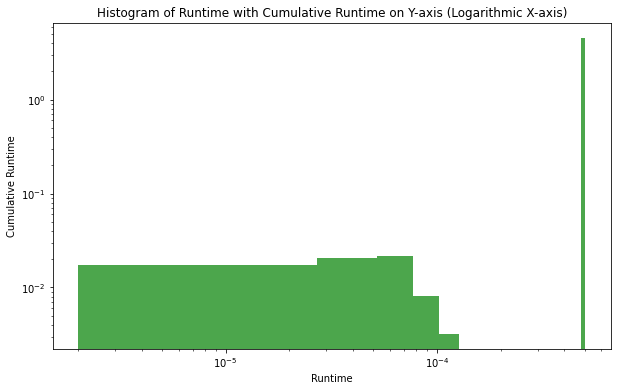

In [24]:
# Output

for fn, df in sweep_dfs.items():
    # sort df decreasingly by 'runtime' column
    df = df.sort_values(by='runtime', ascending=False)
    display(df.head(10))

# loop for each sweep df
for fn, df in sweep_dfs.items():
    print('  {:<25} unique reads={:<5} mean overlap={:.2%}'.format(fn, len(df['query_name'].unique()), df['overlap'].mean()))
    plot_time_hist(df)
#print('  Sweep avg overlap: {:.8}'.format(sweep_df['overlap'].mean()))
#sweep_df.to_csv('out/all.csv', sep='\t', index=False)
#plot_all_columns(sweep_df)


In [8]:
sweep_misaligned_df = sweep_df[sweep_df['overlap'] < 0.1]
sweep_misaligned_df = sweep_misaligned_df[sweep_misaligned_df['overlap'] >= 0]  # remove reads not aligned by minimap
sweep_misaligned_df['start_diff'] = sweep_misaligned_df['ref_start'] - sweep_misaligned_df['from_ref_sim']

display(sweep_misaligned_df[sweep_misaligned_df['start_diff'] > 0])

print('Number of misaligned reads:', sweep_misaligned_df.shape[0])
sweep_misaligned_df.to_csv('out/misalignments.csv', sep='\t', index=False)
#plot_all_columns(sweep_misaligned_df)
display(sweep_misaligned_df)    

NameError: name 'sweep_df' is not defined

In [23]:
def plot_time_hist(df):
    plt.figure(figsize=(10, 6))
    #plt.hist(df["runtime"], cumulative=True, bins=20, log=True)
    plt.hist(df["runtime"], bins=20, cumulative=False, color='green', alpha=0.7, weights=df["runtime"])
    plt.xlabel("Runtime")
    plt.ylabel("Cumulative Runtime")
    plt.title("Histogram of Runtime with Cumulative Runtime on Y-axis (Logarithmic X-axis)")
    plt.xscale("log")
    plt.show()